In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import matplotlib.pyplot as plt
from src.experiments.plot_utils import *
from collections import defaultdict

In [53]:
import scienceplots
plt.style.use([ 'science']) # 'notebook' 'science'
plt.rcParams.update({'font.size': 13})

In [54]:
PLOT_DIR = "../experiments/plots/4-modalities"

BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"
STATS_BASE_FOLDER = BASE_DIR + "stats-experiments/"

STATS_SEARCH_WEIGHTS_DIR = STATS_BASE_FOLDER + "search_weights_exps/"

FIGURE_DPI = 200

In [55]:
def plot_4_modality_search_weights(params, construction_params, search_weights_data, ef=50, plots_dir=PLOT_DIR, num_recalls=100):
    weights = sorted(search_weights_data.keys())
    recalls = []
    for (w1, w2, w3, w4) in weights:
        weight_recalls = search_weights_data[(w1, w2, w3, w4)][ef]
        assert len(weight_recalls[0]) == num_recalls, f"Expected {num_recalls} recalls, but got {len(weight_recalls[0])} for weights {w1}, {w2}, {w3}, {w4} and ef {ef}"
        recalls.append(np.mean(weight_recalls))

    assert len(weights) == len(recalls), f"Expected {len(weights)} weights, but got {len(recalls)} recalls"
    print(f"Plotting {len(weights)} weight-recall points")

    w1, w2, w3, w4 = zip(*weights)
    recalls = np.array(recalls)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # scatter plot
    scatter = ax.scatter(w1, w2, w3, c=recalls, cmap='viridis', s=30)
    ax.set_xlabel('Text weight ($w_1$)')
    ax.set_ylabel('Image weight ($w_2$)')
    ax.set_zlabel('Audio weight ($w_3$)')

    # colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average Recall')

    # plot index weights as a red circle
    ax.scatter(params.weights[0], params.weights[1], params.weights[2], c='red', linewidths=3, s=100, label=f'Index Weights')

    # plot plane
    w1_range = np.linspace(0, 1, 50)
    w2_range = np.linspace(0, 1, 50)
    W1, W2 = np.meshgrid(w1_range, w2_range)
    W3 = 1 - W1 - W2

    # only plot when W3 >= 0
    valid_mask = W3 >= 0
    W1_valid = np.where(valid_mask, W1, np.nan)
    W2_valid = np.where(valid_mask, W2, np.nan)
    W3_valid = np.where(valid_mask, W3, np.nan)
    plane = ax.plot_surface(
        W1_valid, W2_valid, W3_valid,
        color='blue', alpha=0.2, label='$w_1 + w_2 + w_3 = 1$'
    )

    # manually add the plane to the legend (since plot_surface doesn't support legend by default)
    plane._edgecolors2d = plane._edgecolor3d
    plane._facecolors2d = plane._facecolor3d
    ax.legend()

    info_text = (
        f"Dimensions: {params.dimensions}\n"
        f"Metrics: {metrics_to_str(params.metrics)}\n"
        f"Index Weights: {params.weights}\n"
        f"Target Degree: {construction_params.target_degree}\n"
        f"Max Degree: {construction_params.max_degree}\n"
        f"EfConstruction: {construction_params.ef_construction}\n"
        f"EfSearch: {ef}\n"
        f"Video Weight ($w_4$) = 1 - $w_1$ - $w_2$ - $w_3$"
    )

    plt.annotate(
        info_text,
        xy=(0.4, 0.55),
        xycoords='axes fraction',
        bbox=dict(
            boxstyle='round,pad=0.3',
            edgecolor='black',
            facecolor='lightgray'),
        fontsize=12,
        ha='left'
    )

    plt.title(f'Impact of Search Weights on Recall For Equally Weighted 4-Modality Index')
    plt.tight_layout()

    #ax.view_init(elev=10, azim=380)
    ax.view_init(elev=20, azim=-60)

    print(f"Elev: {ax.elev}, Azim: {ax.azim}")

    plt.savefig(f"{plots_dir}/search_weights/recall_3dheatmap_{params.index_size}_{params.metrics[0]}_{params.metrics[1]}_{params.metrics[2]}_{params.metrics[3]}_weights_{round(params.weights[0],3)}_{round(params.weights[1],3)}_{round(params.weights[2],3)}_{round(params.weights[3],3)}_deg_{construction_params.target_degree}_maxdeg_{construction_params.max_degree}_efConstruction_{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}_ef_{ef}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [45]:
params = Params(4, dimensions=[384, 768, 768, 512], metrics=["cosine"]*4, weights=[0.25, 0.25, 0.25, 0.25], index_size=9000)
construction_params = MultiVecHNSWConstructionParams(4, 8, 50, 400)
normalised = "normalised/"

In [46]:
search_weights_data, k = get_search_weights_data(params, construction_params, base_folder=STATS_SEARCH_WEIGHTS_DIR+normalised, modalities=4, prev_index_folder=1)
# search_weights_data: (w1, w2, w3, w4) -> ef -> recall

Loaded index-2025-04-29_20-40-30-191
Read values for k=10 for dataset size 9000 for 19 ef values


In [566]:
point_count = 500
keys = list(search_weights_data.keys())
# select a random subset of search_weights_data
selected = np.random.choice(len(keys), point_count, replace=False)
search_weight_data_to_plot = {}
for key in selected:
    search_weight_data_to_plot[keys[key]] = search_weights_data[keys[key]]
assert len(search_weight_data_to_plot) == point_count

Plotting 500 weight-recall points
Elev: 20, Azim: -60


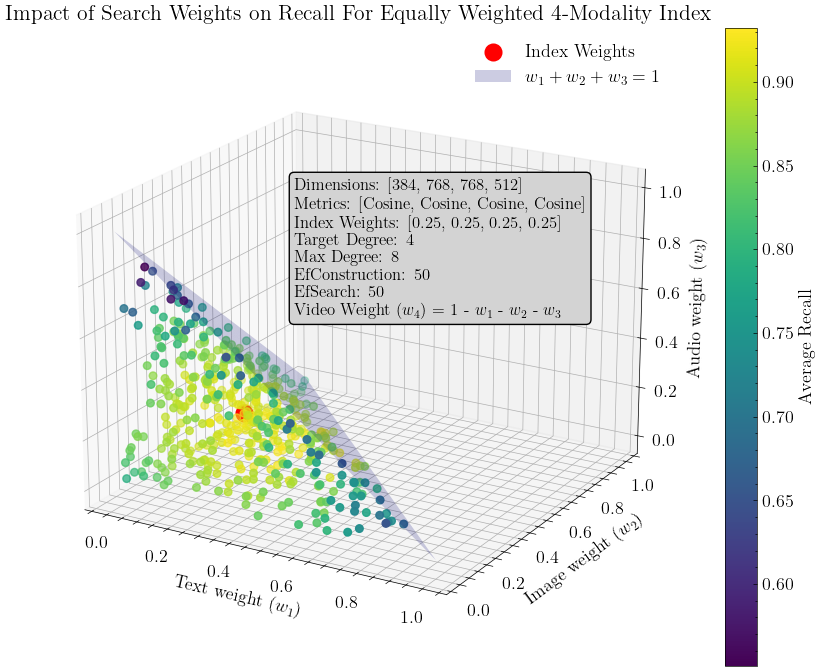

In [567]:
plot_4_modality_search_weights(params, construction_params, search_weight_data_to_plot)

In [57]:
params = Params(3, dimensions=[768, 768, 512], metrics=["cosine"]*3, weights=[1./3.]*3, index_size=9000)
construction_params = MultiVecHNSWConstructionParams(4, 8, 50, 400)
normalised = "normalised/"

In [58]:
search_weights_3_modality_data, k = get_search_weights_data(params, construction_params, base_folder=STATS_SEARCH_WEIGHTS_DIR+normalised, modalities=3, prev_index_folder=1)
# search_weights_data: (w1, w2, w3, w4) -> ef -> recall

Loaded index-2025-04-29_22-46-23-230
Read values for k=10 for dataset size 9000 for 19 ef values


In [59]:
def plot_3_modality_search_weights_heatmap(params, construction_params, search_weights_data, ef=70, plots_dir=PLOT_DIR, num_recalls=100):
    from scipy.interpolate import griddata

    weights = sorted(search_weights_data.keys())
    recalls = []
    for (w1, w2, w3) in weights:
        weight_recalls = search_weights_data[(w1, w2, w3)][ef]
        assert len(weight_recalls[0]) == num_recalls, f"Expected {num_recalls} recalls, but got {len(weight_recalls[0])} for weights {w1}, {w2}, {w3} and ef {ef}"
        recalls.append(np.mean(weight_recalls))

    assert len(weights) == len(recalls), f"Expected {len(weights)} weights, but got {len(recalls)} recalls"
    print(f"Plotting {len(weights)} weight-recall points")

    w1 = np.array([t[1] for t in weights]) # audio
    w2 = np.array([t[2] for t in weights]) #video
    recalls = np.array(recalls)

    # create grid of points
    w1_unique = np.unique(w1)
    w2_unique = np.unique(w2)
    w1_grid, w2_grid = np.meshgrid(w1_unique, w2_unique)

    # interpolate recalls onto the grid
    recall_grid = griddata((w1, w2), recalls, (w1_grid, w2_grid), method='linear')

    plt.figure(figsize=(9, 8))
    # plot contour plot
    contour = plt.contourf(w1_unique, w2_unique, recall_grid.T, levels=30, cmap='viridis')
    plt.colorbar(contour, label='Recall')

    # add line for diagonal
    plt.plot([1, 0], [0, 1], 'k-', lw=2)

    index_weights = [1./3., 1./3.]
    plt.scatter(index_weights[0],index_weights[1], color='red', s=100, label='Index Weights', marker='o')
    plt.annotate('Index Weights',
             xy=index_weights,
             xytext=(index_weights[0]-0.07, index_weights[1]-0.05),
                 color='red',
                 fontsize=12)
             #arrowprops=dict(facecolor='white', arrowstyle='->', lw=1))  # Optional arrow

    plt.xlabel('Audio Weight')
    plt.ylabel('Video Weight')
    plt.title('Impact of Search Weights on Recall For Equally Weighted 3-Modality Index')

    info_text = (
        f"Dimensions: {params.dimensions}\n"
        f"Metrics: {metrics_to_str(params.metrics)}\n"
        f"Index Weights: {[round(x, 3) for x in params.weights]}\n"
        f"Target Degree: {construction_params.target_degree}\n"
        f"Max Degree: {construction_params.max_degree}\n"
        f"EfConstruction: {construction_params.ef_construction}\n"
        f"EfSearch: {ef}\n"
        f"ImageWeight = 1-AudioWeight-VideoWeight"
    )

    plt.annotate(
        info_text,
        xy=(0.45, 0.7),
        xycoords='axes fraction',
        bbox=dict(
            boxstyle='round,pad=0.3',
            edgecolor='black',
            facecolor='lightgray'),
        fontsize=12,
        ha='left'
    )


    plt.savefig(f"{plots_dir}/search_weights/recall-3modalities-heatmap_{params.index_size}_{params.metrics[0]}_{params.metrics[1]}_{params.metrics[2]}_weights_{round(params.weights[0],3)}_{round(params.weights[1],3)}_{round(params.weights[2],3)}_deg_{construction_params.target_degree}_maxdeg_{construction_params.max_degree}_efConstruction_{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}_ef_{ef}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

Plotting 66 weight-recall points


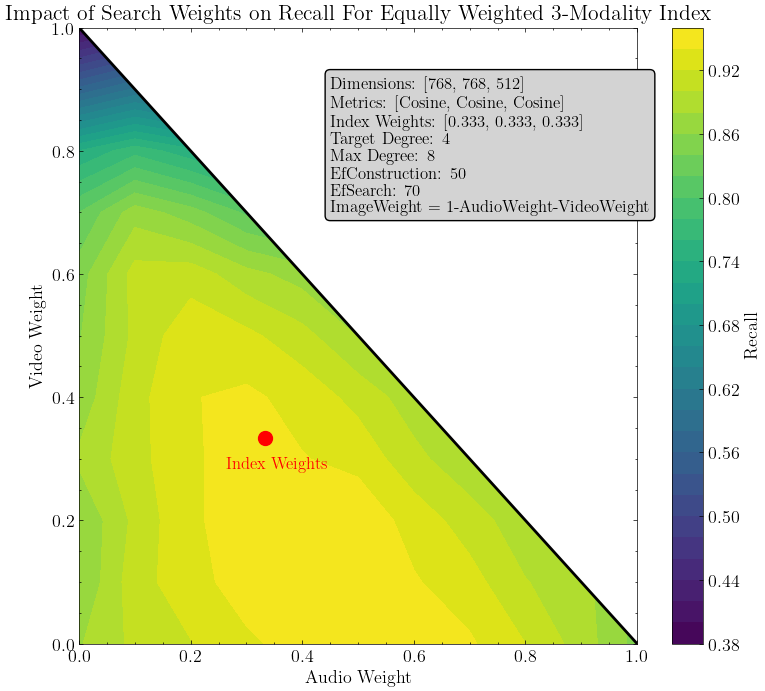

In [60]:
plot_3_modality_search_weights_heatmap(params, construction_params, search_weights_3_modality_data)

In [36]:
# distance computations for 4 modality index.
params = Params(4, [384, 768, 768, 512], [], [], index_size=9000)
construction_params = MultiVecHNSWConstructionParams(4, 8, 50, 400)

print("num modalities:", params.modalities)

normalised="normalised/"
all_combinations_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for metrics in [["cosine", "cosine", "cosine", "cosine"], ["cosine", "manhattan", "euclidean", "cosine"], ["euclidean", "manhattan", "euclidean", "manhattan"]]:
    for index_weights in [[0.25, 0.25, 0.25, 0.25], [0.2, 0.5, 0.1, 0.3], [0.1, 0.1, 0.1, 0.7]]:
        for seed in [400, 401, 402]:
            params.metrics = metrics
            params.weights = index_weights
            construction_params.seed = seed


            data = get_construction_stats(params, construction_params, base_folder=STATS_BASE_FOLDER, normalised=normalised)

            instance_data = all_combinations_data[tuple(metrics)][tuple(index_weights)]
            instance_data["total_distance_calls"].append(data["num_compute_distance_calls"] + data["num_lazy_distance_calls"])
            instance_data["total_vector_computations"].append(instance_data["total_distance_calls"][-1] * params.modalities)
            instance_data["num_lazy_distance_cutoff"].append(data["num_lazy_distance_cutoff"])
            instance_data["num_vectors_skipped_due_to_cutoff"].append(data["num_vectors_skipped_due_to_cutoff"])
            #data["time"]
            #data["num_compute_distance_calls"]
            #data["num_lazy_distance_calls"]
            #data["num_vectors_skipped_due_to_cutoff"]
            #num_compute_distance_calls[text_weight] + num_lazy_distance_calls[text_weight]
all_combinations_data

num modalities: 4


defaultdict(<function __main__.<lambda>()>,
            {('cosine',
              'cosine',
              'cosine',
              'cosine'): defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {(0.25,
                           0.25,
                           0.25,
                           0.25): defaultdict(list,
                                      {'total_distance_calls': [3932153,
                                        3909742,
                                        3891094],
                                       'total_vector_computations': [15728612,
                                        15638968,
                                        15564376],
                                       'num_lazy_distance_cutoff': [array(40633),
                                        array(42893),
                                        array(39630)],
                                       'num_vectors_skipped_due_to_cutoff': [array(41020),
            

In [38]:
for metrics in all_combinations_data:
    for index_weights in all_combinations_data[metrics]:
        total_distance_calls = all_combinations_data[metrics][index_weights]["total_distance_calls"]
        total_vector_computations = all_combinations_data[metrics][index_weights]["total_vector_computations"]
        num_lazy_distance_cutoff = all_combinations_data[metrics][index_weights]["num_lazy_distance_cutoff"]
        num_vectors_skipped_due_to_cutoff = all_combinations_data[metrics][index_weights]["num_vectors_skipped_due_to_cutoff"]

        # calculate mean and confidence interval
        total_dist_mean, total_dist_ci = compute_mean_and_ci_stats(total_distance_calls)
        total_vec_mean, total_vec_ci = compute_mean_and_ci_stats(total_vector_computations)
        num_lazy_dist_mean, num_lazy_dist_ci = compute_mean_and_ci_stats(num_lazy_distance_cutoff)
        num_vec_skipped_mean, num_vec_skipped_ci = compute_mean_and_ci_stats(num_vectors_skipped_due_to_cutoff)

        scale_factor = 10**5
        print(f"Metrics: {[m[0].upper() for m in metrics]}, Index Weights: {index_weights}")
        print(f"    Distance Computations:               {total_dist_mean/scale_factor} ({total_dist_ci/scale_factor})")
        #print(f"    Total Vector Computations:          {total_vec_mean/scale_factor} ({total_vec_ci/scale_factor})")
        print(f"    Distance Computations Cutoff:           {num_lazy_dist_mean/scale_factor} ({num_lazy_dist_ci/scale_factor})")
        print(f"    Vectors Cutoff:  {num_vec_skipped_mean/scale_factor} ({num_vec_skipped_ci/scale_factor})")

        print(f"    Distances Cutoff (%):          {num_lazy_dist_mean / total_dist_mean * 100:.2f}%")
        print(f"    Vectors Cutoff (%):          {num_vec_skipped_mean / total_vec_mean * 100:.2f}%")



Metrics: ['C', 'C', 'C', 'C'], Index Weights: (0.25, 0.25, 0.25, 0.25)
    Distance Computations:               39.10996333333333 (0.5106944806319642)
    Distance Computations Cutoff:           0.41052 (0.041519023401698385)
    Vectors Cutoff:  0.41581666666666667 (0.04298249101503242)
    Distances Cutoff (%):          1.05%
    Vectors Cutoff (%):          0.27%
Metrics: ['C', 'C', 'C', 'C'], Index Weights: (0.2, 0.5, 0.1, 0.3)
    Distance Computations:               37.12457333333334 (1.3752782232131393)
    Distance Computations Cutoff:           18.171133333333334 (0.792175662625917)
    Vectors Cutoff:  19.6239 (0.8358327526269123)
    Distances Cutoff (%):          48.95%
    Vectors Cutoff (%):          13.21%
Metrics: ['C', 'C', 'C', 'C'], Index Weights: (0.1, 0.1, 0.1, 0.7)
    Distance Computations:               39.168796666666665 (0.625896983687532)
    Distance Computations Cutoff:           11.355003333333332 (0.1974178019569622)
    Vectors Cutoff:  20.02164 (0.40151